In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [31]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [4]:
style.use('ggplot')

In [3]:
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [6]:
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

0

In [7]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

In [ ]:
df['moving_distance'] = np.abs(df.latitude.diff() * 111000) + np.abs(df.longitude.diff() * 110987)

In [9]:
X = np.array(list(zip(df.hr_value, df.step_value)))

In [22]:
# Number of clusters
k = 2
# X coordinates of random centroids
C_x = np.random.randint(0, np.max(X)-30, size=k)
# Y coordinates of random centroids
C_y = np.random.randint(0, np.max(X)-30,size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
# C_x = [-2, 6]
# C_y = [4, -6]
# C = np.array(list(zip(C_x,C_y)))
print(C)

[[160. 211.]
 [ 69. 182.]]


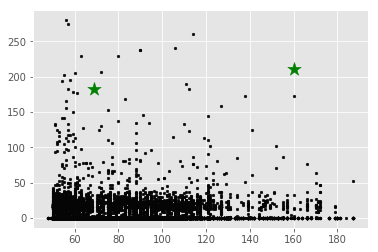

In [23]:
# Plotting along with the Centroids
fig = plt.figure()
plt.scatter(df.hr_value, df.step_value, c='#050505', s=7)
plt.scatter(C_x, C_y, marker='*', s=200, c='g')
plt.show()

In [24]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [25]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster    
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)
    clear_output(wait=True)
    print(error)

0.0


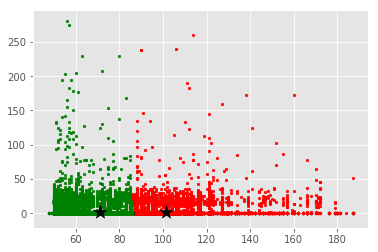

In [26]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')
plt.show()

In [28]:
df['cluster'] = clusters
df['clusterDiff'] = df.cluster.diff()

In [29]:
dftspdiff = df['timestamp'].diff()
dftfdiffSTD = dftspdiff.rolling(20).std()

# find the place that std is smaller than 5
lis = []
changeFlag = 0
tempt = [0]
for i in range(len(dftfdiffSTD)):
    if dftfdiffSTD[i] < 5 and changeFlag == True and len(tempt) < 2:
        tempt.append(i)
        changeFlag = False
    if dftfdiffSTD[i] >= 5 and changeFlag == False and len(tempt) < 2:
        tempt.append(i-1)
        changeFlag = True
    if len(tempt) == 2:
        lis.append(tempt)
        tempt = []
# print(lis)

In [30]:
data_with_gap = []
for i in lis:
    data_with_gap.append(df[i[0]:i[1]])

In [55]:
in_seq = np.array(df['cluster'])
in_seq

array([1., 1., 1., ..., 1., 1., 1.])

In [85]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix].reshape(len(sequences[i:end_ix]),1) 
        seq_y =  sequences[end_ix]
        X.append(seq_x)
        y.append([seq_y])
    return np.array(X), np.array(y)

In [35]:
dftspdiff = df['timestamp'].diff()
dftfdiffSTD = dftspdiff.rolling(20).std()
# find the place that std is smaller than 5
lis = []
changeFlag = 0
tempt = [0]
for i in range(len(dftfdiffSTD)):
    if dftfdiffSTD[i] < 5 and changeFlag == True and len(tempt) < 2:
        tempt.append(i)
        changeFlag = False
    if dftfdiffSTD[i] >= 5 and changeFlag == False and len(tempt) < 2:
        tempt.append(i-1)
        changeFlag = True
    if len(tempt) == 2:
        lis.append(tempt)
        tempt = []

class DataGenerator(keras.utils.Sequence):
    # Generates data for keras
    def __init__(self, lis_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        # Initializtion
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        # Denotes the number of batches per batch
        return int(np.floor(len(self.list_IDS) / self.batch_size))
    
    def __getitem__(self, index):  # Generate one batch of data
        # Genrate indexs of the batch
        indexes = self.indexes[lis[index][0]:lis[index][0]]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arrange(len(self.list_IDs))
        if self.shuffle == Ture:
            np.random.shuffle(slef.indexes)
    
    # Generates data containing batch_size smaples X ; (n_smaples, *dim, n_channels)
    def __data_generation(self, sequences, list_IDs_temp): 
        # Initializtion
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)
        X, y = list(), list()
        
        for i in range(list_IDs_temp):
            # find the end of this pattern
            end_ix = i + *self.dim
            # check if we are beyond the dataset
            if end_ix > len(sequences)-1:
                break
            # gather input and output parts of the pattern
            seq_x = sequences[i:end_ix].reshape(len(sequences[i:end_ix]),1) 
            seq_y =  sequences[end_ix]
            X.append(seq_x)
            y.append([seq_y])
        return np.array(X), np.array(y)

In [101]:
training_generator = DataGenerator(in_seq)

TypeError: __init__() missing 1 required positional argument: 'labels'

In [96]:
n_steps = 50
X, y = split_sequences(in_seq, n_steps)
for i in range(1):
    print(X[i], y[i])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] [1.]


In [97]:
n_features = 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50 ,activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 49, 64)            192       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                76850     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 77,093
Trainable params: 77,093
Non-trainable params: 0
_________________________________________________________________


In [98]:
X.shape

(61704, 50, 1)

In [99]:
history = model.fit(X, y, epochs=100, verbose=0, batch_size=128, validation_split=0.2)

<IPython.core.display.Javascript object>


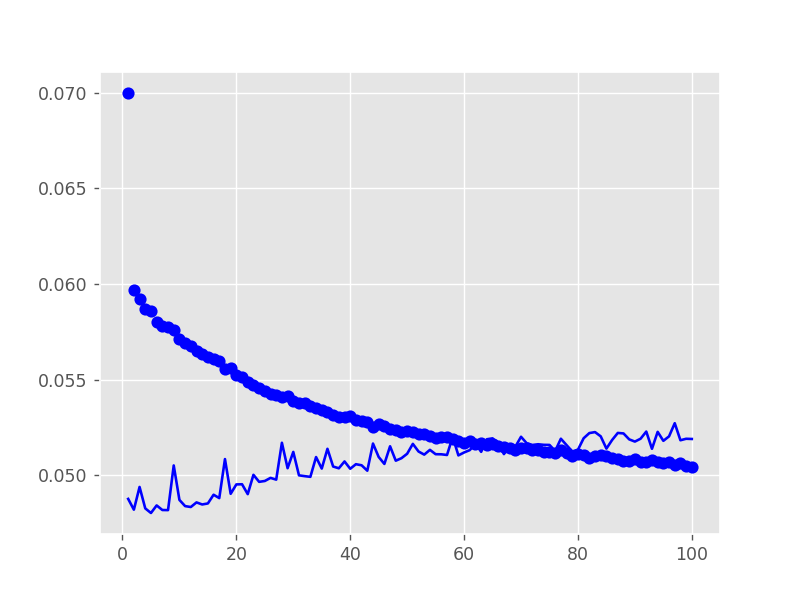

In [100]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()